In [1]:
import json, os, datetime, collections, commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

if not os.path.exists("./click_data_sample.csv"):
    print "csv file not found at driver node, will download and copy to HDFS"
    commands.getoutput("wget -q http://image.gihyo.co.jp/assets/files/book/2015/978-4-7741-7631-4/download/click_data_sample.csv")
    commands.getoutput("hadoop fs -copyFromLocal -f ./click_data_sample.csv /user/hadoop/")

whole_raw_log = sc.textFile("/user/hadoop/click_data_sample.csv")
header = whole_raw_log.first()

whole_log = whole_raw_log.filter(lambda x:x !=header).map(lambda line: line.split(","))\
            .map(lambda line: [datetime.datetime.strptime(line[0].replace('"', ''), '%Y-%m-%d %H:%M:%S'), line[1], line[2].replace('"', '')])
whole_log.repartition(4).cache()
whole_log.take(2)

/usr/local/lib64/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


[[datetime.datetime(2015, 4, 27, 20, 40, 40), u'144012', u'Campaign077'],
 [datetime.datetime(2015, 4, 27, 0, 27, 55), u'24485', u'Campaign063']]

##Step1 Check the number of access deviation
* using histgram and pie-chart for num of access VS num of user
* identify "light user" by k-means clustering

[916, 767, 761, 636, 596, 550, 548, 540, 529, 501]


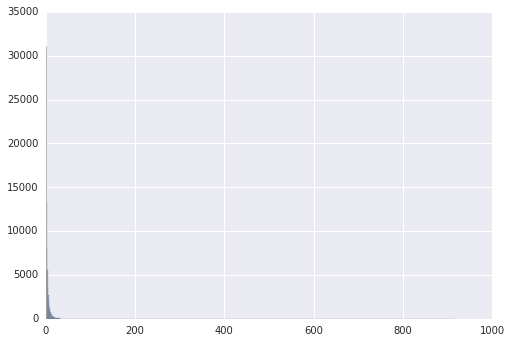

In [2]:
#countByValue() returns just a dict, not RDD.
access_by_user = whole_log.map(lambda record:record[1]).countByValue().items()
num_of_access = sorted (map(lambda line: line[1], access_by_user), reverse=True)
print num_of_access[:10]

sns.set(color_codes=True)
sns.distplot(num_of_access, kde=False, norm_hist=False, bins=1000)

[(1, 31022), (2, 13273), (3, 7974), (4, 5510), (5, 3745), (6, 2736), (7, 2070), (8, 1618), (38, 21), (10, 1003)]


(-1.0209358530534713, 1.0027764804222687, -1.0017105272894256, 1.0)

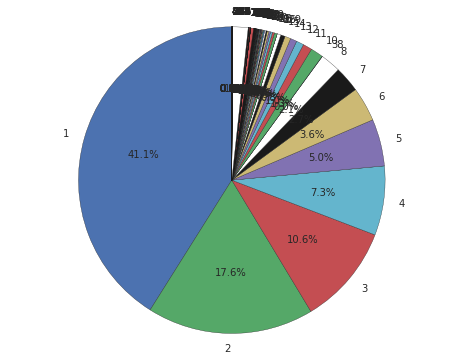

In [3]:
num_usage_count_list = collections.Counter(num_of_access).items()
print num_usage_count_list[:10]

num_usage_label = map(lambda item: item[0], num_usage_count_list)
num_usage_num  = map(lambda item: item[1], num_usage_count_list)

#Use pyplot as Seaborn not supporting pie-chart https://github.com/mwaskom/seaborn/issues/766
plt.pie(num_usage_num, labels=num_usage_label, startangle=90, autopct="%1.1f%%")
plt.axis("equal")

#### Finding from histgram and pie-chart
* 75% user has access <=4, need to remove "light user" for further analysis
* First, create cluster to identify "light user"

## Step2 : Extract "heavy use" users with removing 1st cluster
* only filter top 4615 users (they are accessing heavily), and create pie-for confirmation

#### Calculate cluster
* `CreateCluster.cluster` is cluster object
  * `initializationMode` should be `random` or `k-means||`
* `CreateCluster.clulster_deviation` returns cluster's WSSSE value
* `CreateCluster.each_cluster_users` returns cluster ID and number of user belong to this cluster
* `CreateCluster.clulster_center` returns center cordinate of each cluster
* Refer [this page](http://spark.apache.org/docs/latest/mllib-clustering.html#k-means)

In [4]:
from pyspark.mllib.clustering import KMeans, KMeansModel
from pyspark.mllib.linalg import DenseVector
from pyspark.mllib.linalg import SparseVector
from numpy import array
from math import sqrt

class CreateCluster:
    def __init__(self, input_rdd, num_of_cluster):
        self.cluster = KMeans.train(input_rdd, num_of_cluster, maxIterations=100, runs=100, initializationMode="k-means||")
        self.clulster_deviation = input_rdd.map(lambda point: self.__calculate_deviation(point)).reduce(lambda x, y: x + y)
        self.each_cluster_users = input_rdd.map(lambda point: self.__which_cluster(point)).countByValue().items()
        self.which_cluster = input_rdd.map(lambda point: self.__which_cluster(point)).collect()
        self.clulster_center = self.cluster.centers
        
    def __calculate_deviation(self, point):
        center = self.cluster.centers[self.cluster.predict(point)]
        return sqrt(sum([x**2 for x in (point - center)]))

    def __which_cluster(self, point):
        return self.cluster.predict(point)

Cluster#, WSSSE value, [Center centers], [(ClusterID, Number of user)]
1 415490 [4.3] [(0, 75545)]
2 364957 [262.8, 3.9] [(0, 125), (1, 75420)]
3 337732 [3.7, 103.2, 379.1] [(0, 75201), (1, 290), (2, 54)]
4 245752 [2.8, 398.3, 136.9, 20.3] [(0, 70930), (1, 47), (2, 175), (3, 4393)]
5 234219 [2.7, 304.2, 634.4, 115.7, 18.6] [(0, 70203), (1, 54), (2, 10), (3, 195), (4, 5083)]
6 192066 [12.4, 634.4, 305.9, 136.7, 2.3, 42.9] [(0, 8307), (1, 10), (2, 53), (3, 128), (4, 66330), (5, 717)]
7 156203 [2.0, 9.1, 180.1, 332.6, 26.0, 79.6, 634.4] [(0, 61524), (1, 11867), (2, 77), (3, 38), (4, 1805), (5, 224), (6, 10)]
8 136896 [1.8, 332.6, 45.1, 103.4, 18.1, 7.2, 187.8, 634.4] [(0, 57779), (1, 38), (2, 485), (3, 117), (4, 3302), (5, 13749), (6, 65), (7, 10)]
9 138136 [7.4, 47.2, 521.3, 103.6, 319.9, 1.8, 814.7, 185.7, 19.3] [(0, 14267), (1, 419), (2, 10), (3, 116), (4, 37), (5, 57779), (6, 3), (7, 63), (8, 2851)]


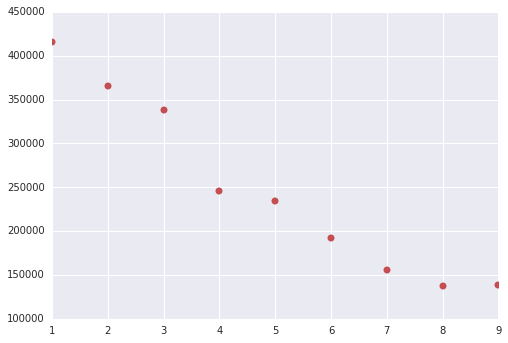

In [5]:
#Ugly hack, to perform cluster for list (one dimension), create 2 dimension RDD
num_of_access_rdd = sc.parallelize(map(lambda item: [item,item], num_of_access))
WSSSE_list = []
max_cluster = 10

print "Cluster#, WSSSE value, [Center centers], [(ClusterID, Number of user)]"
for count in range (1, max_cluster):
    full_user_cluster = CreateCluster(num_of_access_rdd, count)
    center_value_list = []
    for center_value in full_user_cluster.clulster_center:
        center_value_list.append(round(center_value[0],1))
    print count, int(full_user_cluster.clulster_deviation), center_value_list, full_user_cluster.each_cluster_users
    WSSSE_list.append([count, full_user_cluster.clulster_deviation])

deviation_nparray = np.array(WSSSE_list, dtype=int)
plt.plot(deviation_nparray[:,0], deviation_nparray[:,1], "ro")

#### Finding by WSSSE
* cluster size of 4 is good enough (as it is the "elbow" of WSSSE graph)
* when removing 1st cluster (less click users) and keep 2nd-4th cluster, need to keep 4615 users

4615
[(u'22975', 916), (u'30292', 767), (u'107624', 761), (u'41760', 636), (u'121150', 596)]
[916, 767, 761, 636, 596]


(-1.0021614131608503, 1.0000686053067416, -1.0009510858718711, 1.0)

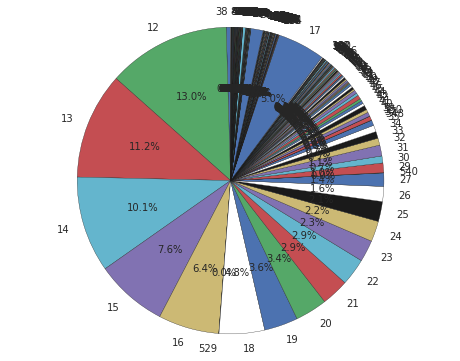

In [6]:
# extract top 4615 uses
num_extract = 4615
access_by_heavy_user = sorted (access_by_user, key=lambda item: item[1], reverse=True)[:num_extract]
num_of_access_heavy_user = sorted (map(lambda line: line[1], access_by_heavy_user), reverse=True)

print len(access_by_heavy_user)
print access_by_heavy_user[:5]
print num_of_access_heavy_user[:5]

# Create pie-chart to check the num-of-user vs num-of-access
num_heavy_usage_count_list = collections.Counter(num_of_access_heavy_user).items()
num_heavy_usage_label = map(lambda item: item[0], num_heavy_usage_count_list)
num_heavy_usage_num  = map(lambda item: item[1], num_heavy_usage_count_list)

plt.pie(num_heavy_usage_num, labels=num_heavy_usage_label, startangle=90, autopct="%1.1f%%")
plt.axis("equal")

## Step3 : Create normalized userID list for each campain, and process PCA
* (1)filter-out from original logs which is not "heavy user".
* (2)convert the log like following
  * from [[user1, campain1], [user1, campain3], [user2, campain2], [user1, campain1]]
  * to [[user1, 0.66, 0.0, 0.33], [user2, 0.0, 1.0, 0.0]] (with Pandas Dataframe form)
* (3)process "normalized userID list for each campain" with PCA, and get the scores on PCA'ed dimension
* (4)process k-means for the the scores (of PCA'ed dimension), and create userID list for each cluster

In [7]:
heavy_user_nparray = np.array(access_by_heavy_user, dtype=int)

# list of userID  of heavy user 
heavy_userID_rdd = sc.broadcast(list(heavy_user_nparray[:,0]))

#First, filter out the original log only for the heavy_userID
heavy_user_whole_log = whole_log.filter(lambda item: int(item[1]) in heavy_userID_rdd.value).map(lambda item: [int(item[1]), item[2]])
heavy_user_whole_log.repartition(3).cache()
print heavy_user_whole_log.take(5), heavy_user_whole_log.count()

[[24485, u'Campaign063'], [24485, u'Campaign063'], [24485, u'Campaign038'], [24485, u'Campaign063'], [167405, u'Campaign027']] 132030


In [8]:
#use Spark DataFrame to perform "groupBy -> agg"
from pyspark.sql import SQLContext, Row
from pyspark.sql.types import *

fields = [StructField("userID", IntegerType(), True), StructField("campainID", StringType(), True)]
heavy_user_df = sqlContext.createDataFrame(heavy_user_whole_log, StructType(fields))
heavy_user_agged_df = heavy_user_df.groupBy("userID", "campainID").agg({"campainID": "count"})
heavy_user_agged_df.show(10)

+------+-----------+----------------+
|userID|  campainID|count(campainID)|
+------+-----------+----------------+
|169114|Campaign112|               1|
| 34998|Campaign097|              11|
| 82209|Campaign090|               1|
| 14823|Campaign100|              10|
| 11715|Campaign052|               4|
| 13340|Campaign129|               1|
| 85422|Campaign116|              26|
| 55885|Campaign025|               3|
| 34966|Campaign028|               1|
| 95704|Campaign103|               9|
+------+-----------+----------------+
only showing top 10 rows



In [9]:
def merge_dict_addValue(d1, d2):
  totals = collections.Counter()
  totals.update(d1)
  totals.update(d2)
  return dict(totals)

heavy_user_agged_rdd    = heavy_user_agged_df.map(lambda item: [ int(item[0]), {item[1]: int(item[2]) }] )
heavy_user_reduced_rdd = heavy_user_agged_rdd.reduceByKey(lambda x,y: merge_dict_addValue(x,y) )
heavy_user_reduced_rdd.take(5)

[(86016,
  {u'Campaign027': 6,
   u'Campaign090': 2,
   u'Campaign123': 2,
   u'Campaign131': 2}),
 (47106,
  {u'Campaign014': 7,
   u'Campaign025': 5,
   u'Campaign040': 2,
   u'Campaign072': 1}),
 (67590, {u'Campaign027': 24, u'Campaign090': 4, u'Campaign131': 11}),
 (117420, {u'Campaign010': 5, u'Campaign055': 5, u'Campaign103': 7}),
 (74538, {u'Campaign083': 11, u'Campaign119': 2})]

In [10]:
#create list of userID and campainID
raw_campain_list = heavy_user_reduced_rdd.map(lambda item:item[1].keys()).reduce(lambda x,y:x+y) 
sorted_campain_list = sorted(list(set(raw_campain_list)))

raw_userID_list = heavy_user_reduced_rdd.map(lambda item:item[0]).collect() 
sorted_userID_list =sorted(raw_userID_list)

#create pandas of userID x campainID, and fill nuber of access
pd_df_raw = pd.DataFrame(0, index=sorted_userID_list, columns=sorted_campain_list)
for item in heavy_user_reduced_rdd.collect():
    for keys in item[1].items():
        pd_df_raw.ix[item[0], keys[0]] = keys[1]

#normalize each rows, to make each row's sum to be 1
normalized_pd_df = pd_df_raw.div(pd_df_raw.sum(axis=1), axis=0).astype(float)


In [11]:
print normalized_pd_df.iloc[0].values
print normalized_pd_df.iloc[1].values
print normalized_pd_df.iloc[2].values
print normalized_pd_df.iloc[3].values

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.07692308  0.          0.          0.          

#### Convert to Spark Dataframe with "Dense Vector" from normilized Pandas Dataframe
* Current MLLib's PCA only accept list of Spark Dataframe with Densevector
* **map(list, normalized_pd_df.values)** returns list of [[np.float64, np.float64..],[np.float64, np.float64..]] - which is np.float64.
* float64 have to be convert to normal float, like [ (Vectors.dense([float, float..]), ), (Vectors.dense([float, float..]), )...]

In [12]:
from pyspark.ml.feature import *
from pyspark.mllib.linalg import Vectors

densevector_list = []
for normalized_pd_df_one_line in map(list, normalized_pd_df.values):
    densevector_one_list = []
    for pd_df_item in normalized_pd_df_one_line:
        densevector_one_list.append(np.float64(pd_df_item).item())
    densevector_list.append((Vectors.dense(densevector_one_list),))

#Finally, we get Spark Dataframe with "Dense Vector"
spark_normalized_df = sqlContext.createDataFrame(densevector_list, ["features"])

#### Process PCA and get the scores on PCA'ed dimension
* current MLLib's PCA only returns scores (=`eigenvalues` of PCA'ed dimension), does not give us `eigenvectors` and `explained variance` for each `eigenvector`
* Refering [this article](http://stackoverflow.com/questions/33428589/pyspark-and-pca-how-can-i-extract-the-eigenvectors-of-this-pca-how-can-i-calcu), to calculate `eigenvectors` and `explained variance`

In [13]:
from numpy.linalg import eigh
from pyspark.mllib.linalg import *

def estimateCovariance(df):
    m = df.select(df["features"]).map(lambda x: x[0]).mean()
    dfZeroMean = df.select(df["features"]).map(lambda x: x[0]).map(lambda x: x-m)  # subtract the mean
    return dfZeroMean.map(lambda x: np.outer(x,x)).sum()/df.count()

        
def pca(df, k=2):
    cov = estimateCovariance(df)
    col = cov.shape[1]
    eigVals, eigVecs = eigh(cov)
    inds = np.argsort(eigVals)
    eigVecs = eigVecs.T[inds[-1:-(col+1):-1]]  
    components = eigVecs[0:k]
    eigVals = eigVals[inds[-1:-(col+1):-1]]  # sort eigenvalues
    score = df.select(df["features"]).map(lambda x: x[0]).map(lambda x: np.dot(x, components.T) )
    scoreDF = sqlContext.createDataFrame(score.map(lambda x: (DenseVector(x),)), ["pca_features"])
    return components.T, scoreDF, eigVals

        
def varianceExplained(df, k=1):
    eigenvalues = pca(df,k)[2] 
    return sum(eigenvalues[0:k])/sum(eigenvalues)

In [14]:
pca_extracted = PCA(k=len(sorted_campain_list), inputCol="features", outputCol="pca_features")
model = pca_extracted.fit(spark_normalized_df)

# comp is numpy array object, and PCA'ed vectors (eigenvectors)
# score is RDD object, and coordinates of each sample at PCA'ed vectors
# eigVals is numpy array object, percentage of variance explained for PCA'ed vectors

comp, score, eigVals = pca(spark_normalized_df, k=len(sorted_campain_list))
Sum_contribution = 0
for each_eigVal in eigVals:
    Sum_contribution += each_eigVal
    print Sum_contribution/sum(eigVals)

0.111139239317
0.19765807487
0.270689655737
0.337422058185
0.38393293426
0.413260088709
0.440499432452
0.464875506158
0.485504556269
0.505337658115
0.523701619877
0.541522217842
0.558573537439
0.575202109881
0.59161515597
0.607405379646
0.622266049224
0.636886431662
0.649603028097
0.660813508973
0.671414962388
0.681770463105
0.692119450403
0.702231343522
0.712136398097
0.721545023898
0.730570077023
0.739383151014
0.747943859773
0.756362509905
0.764712620173
0.773006466433
0.780594345261
0.787763756056
0.794578184947
0.801278733892
0.807638204518
0.813936829873
0.819984204578
0.825721347576
0.831316808539
0.836880333661
0.842103895727
0.847140536714
0.852074137945
0.857001413032
0.861837658051
0.866496049581
0.871019888126
0.87547231175
0.879828974626
0.884180539615
0.888477144346
0.892658884213
0.896717821835
0.900757349088
0.904633776535
0.908315919081
0.911667105308
0.914939660912
0.918152288092
0.921316319406
0.924365220605
0.927321750697
0.93021033609
0.933028909854
0.935798539611


#### Can reduce the outliers by removing low scores on PCA'ed dimension
* Original log has 133 parameters (campain001 to 133, might have less numbers if you reduce the target user).
* this *num_new_dimension* means only keeps top xx params of at PCA'ed dimenstion (to remove outliers(外れ値)).
* When seeing the sum of variance explained, top 36 can explain 80%, so will remove #37 or lower dimenstions 

In [15]:
num_new_dimension = 36

#score.collect() retunrs list of "Pyspark DenseVector", thus need "tolist()"
pca_converted_score = []
for each_score in score.collect():
    pca_converted_score.append(each_score[0].tolist()[:num_new_dimension])

print len(pca_converted_score), len(pca_converted_score[0])
print pca_converted_score[0]

4615 36
[0.012991190136479754, -0.006671423647828865, 0.0015734684158475898, -0.006962110319470609, 0.08442495463203536, 0.04764228552579725, -0.04273739944688369, 0.249639955298965, 0.8162015105477881, -0.4631590626992834, 0.06000345092343135, -0.10501081368416164, 0.011354406776460435, 0.0102347299596541, -0.04595585876610297, 0.0169049970242838, -0.06341979465882117, 0.0010774499747916602, 0.07346137494869247, 0.044397281830941736, -0.021447730071713564, -0.004471163038078976, -0.007699762728653565, 0.02483635656900492, -0.001436257512657762, 0.023749138493781484, -0.0037942635547112444, 0.010283519032304142, -0.014768782541750203, -0.0021076179257598325, 0.0013082656773329253, -0.002945674601731209, 0.013830728926499471, -0.02644451137004236, 0.011865570441636742, -0.0005234305417112446]


## Step4 : Process k-means based on PCA'ed dimension scores 
* process k-means for the the scores (of PCA'ed dimension), and create userID list for each cluster

cluster#, WSSSE value, [(ClusterID, Number of user)]
1 2870 [(0, 4615)]
2 2588 [(0, 3754), (1, 861)]
3 2374 [(0, 859), (1, 3515), (2, 241)]
4 2221 [(0, 3320), (1, 859), (2, 241), (3, 195)]
5 2015 [(0, 2749), (1, 241), (2, 195), (3, 856), (4, 574)]
6 1839 [(0, 843), (1, 573), (2, 597), (3, 241), (4, 2166), (5, 195)]
7 1773 [(0, 107), (1, 573), (2, 241), (3, 595), (4, 2061), (5, 195), (6, 843)]
8 1735 [(0, 573), (1, 48), (2, 595), (3, 2013), (4, 195), (5, 241), (6, 107), (7, 843)]
9 1671 [(0, 573), (1, 1887), (2, 241), (3, 195), (4, 129), (5, 46), (6, 597), (7, 107), (8, 840)]


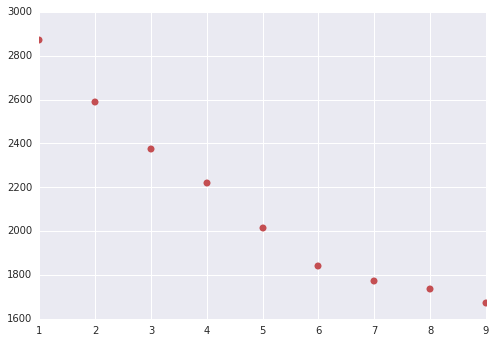

In [16]:
max_cluster = 10
WSSSE_list = []
pca_converted_rdd = sc.parallelize(pca_converted_score)

print "cluster#, WSSSE value, [(ClusterID, Number of user)]"
for count in range (1, max_cluster):
    pca_converted_cluster = CreateCluster(pca_converted_rdd, count)
    print count, int(pca_converted_cluster.clulster_deviation), pca_converted_cluster.each_cluster_users
    WSSSE_list.append([count, pca_converted_cluster.clulster_deviation])

deviation_nparray = np.array(WSSSE_list, dtype=int)
plt.plot(deviation_nparray[:,0], deviation_nparray[:,1], "ro")

#### Finding by WSSSE
* cluster size of 6 is good enough (as it is the "elbow" of WSSSE graph)

## Step5 : Create charts of each cluster's characteristic against campains
* create list of [userID, cluseter_belong_to]
* calculate average usage for each campain by cluster, and make each cluster's graphs against campains
* chech the each cluster's characteristic against campains

[[97, 5], [136, 5], [142, 5], [143, 5], [252, 5], [358, 4], [374, 3], [489, 1], [492, 4], [507, 5]]
4615


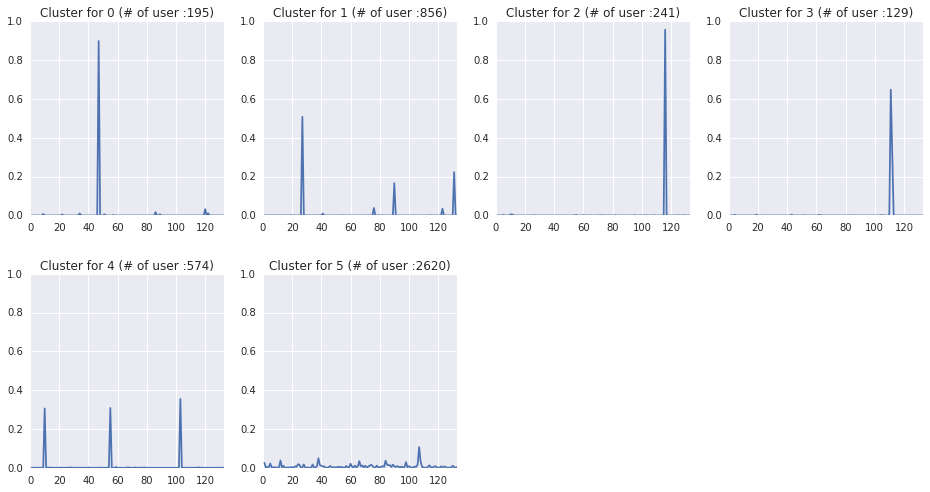

In [17]:
cluster_size = 6
pca_converted_cluster = CreateCluster(pca_converted_rdd, cluster_size)

pca_converted_cluster_list = pca_converted_cluster.which_cluster

heavy_user_pca_clustered = []
for count in range(0, len(sorted_userID_list)):
    heavy_user_pca_clustered.append([sorted_userID_list[count], pca_converted_cluster_list[count]])

#list of [userID, cluseter_belong_to]
print heavy_user_pca_clustered[:10]
print len(heavy_user_pca_clustered)

num_of_campains = len(sorted_campain_list)
average_use_for_clusters = []

for count in range(0, cluster_size):
    average_use_for_clusters.append(np.zeros(num_of_campains, dtype=float))

#Just add all rows (not average)
for count_cluster_type in heavy_user_pca_clustered:
    average_use_for_clusters[count_cluster_type[1]] += np.array(normalized_pd_df.loc[count_cluster_type[0]].values.tolist())

#Create chart
plt.figure(figsize=(16,8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)
for count in range(0, cluster_size):
    #Convert to average from just sum
    average_use_for_clusters[count] = average_use_for_clusters[count]/pca_converted_cluster.each_cluster_users[count][1]
    subplot = plt.subplot( int(len(pca_converted_cluster.each_cluster_users)/4)+1, 4, count+1)
    subplot.set_xlim([0, num_of_campains])
    subplot.set_ylim([0, 1])
    subplot.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    subplot.set_title("Cluster for " + str(count) + " (# of user :" + str(pca_converted_cluster.each_cluster_users[count][1]) + ")")
    plt.plot(range(1, num_of_campains+1, 1), average_use_for_clusters[count])

## Step6 : Create cluster without PCA pre-processing
* use k-means directly for "normalized userID list for each campain" wihtout PCA
* create chart same as Step5.
* see the result difference between Step6(without PCA) and Step5(with PCA as pre-processing)

In [18]:
wihtout_pca_converted_score = []

for count in range (0, len(sorted_userID_list)):
    wihtout_pca_converted_score.append(normalized_pd_df.iloc[count].values)

cluster#, WSSSE value, [(ClusterID, Number of user)]
1 3308 [(0, 4615)]
2 3039 [(0, 3752), (1, 863)]
3 2828 [(0, 3515), (1, 241), (2, 859)]
4 2640 [(0, 574), (1, 856), (2, 2944), (3, 241)]
5 2492 [(0, 856), (1, 241), (2, 2749), (3, 195), (4, 574)]
6 2421 [(0, 574), (1, 240), (2, 195), (3, 2533), (4, 860), (5, 213)]
7 2381 [(0, 611), (1, 195), (2, 213), (3, 857), (4, 240), (5, 129), (6, 2370)]
8 2248 [(0, 2057), (1, 844), (2, 601), (3, 241), (4, 49), (5, 195), (6, 573), (7, 55)]
9 2208 [(0, 597), (1, 49), (2, 840), (3, 573), (4, 1847), (5, 212), (6, 195), (7, 240), (8, 62)]


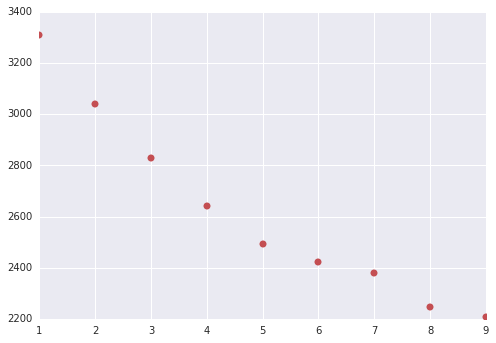

In [19]:
max_cluster = 10
WSSSE_list = []

without_pca_converted_rdd = sc.parallelize(wihtout_pca_converted_score)

print "cluster#, WSSSE value, [(ClusterID, Number of user)]"
for count in range (1, max_cluster):
    wihtout_pca_converted_cluster = CreateCluster(without_pca_converted_rdd, count)
    print count, int(wihtout_pca_converted_cluster.clulster_deviation), wihtout_pca_converted_cluster.each_cluster_users
    WSSSE_list.append([count, wihtout_pca_converted_cluster.clulster_deviation])

deviation_nparray = np.array(WSSSE_list, dtype=int)
plt.plot(deviation_nparray[:,0], deviation_nparray[:,1], "ro")

#### Finding by WSSSE
* cluster size of 6 is good enough (as it is the "elbow" of WSSSE graph)

[[97, 1], [136, 1], [142, 1], [143, 1], [252, 1], [358, 0], [374, 3], [489, 5], [492, 0], [507, 1]]
4615


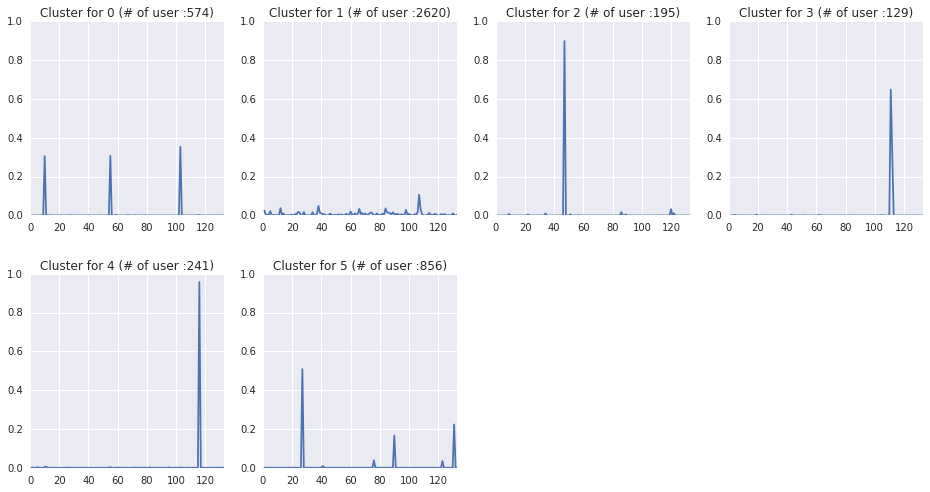

In [20]:
cluster_size = 6
wihtout_pca_converted_cluster = CreateCluster(without_pca_converted_rdd, cluster_size)

without_pca_converted_cluster_list = wihtout_pca_converted_cluster.which_cluster
heavy_user_withou_pca_clustered = []

for count in range(0, len(sorted_userID_list)):
    heavy_user_withou_pca_clustered.append([sorted_userID_list[count], without_pca_converted_cluster_list[count]])

#list of [userID, cluseter_belong_to]
print heavy_user_withou_pca_clustered[:10]
print len(heavy_user_withou_pca_clustered)

#Try to list of [userID, cluseter_belong_to]
num_of_campains = len(sorted_campain_list)
average_use_for_clusters = []

for count in range(0, cluster_size):
    average_use_for_clusters.append(np.zeros(num_of_campains, dtype=float))

#Just add all rows (not average)
for count_cluster_type in heavy_user_withou_pca_clustered:
    average_use_for_clusters[count_cluster_type[1]] += np.array(normalized_pd_df.loc[count_cluster_type[0]].values.tolist())

#Create chart
plt.figure(figsize=(16,8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)
for count in range(0, cluster_size):
    #Convert to average from just sum
    average_use_for_clusters[count] = average_use_for_clusters[count]/wihtout_pca_converted_cluster.each_cluster_users[count][1]
    subplot = plt.subplot( int(len(wihtout_pca_converted_cluster.each_cluster_users)/4)+1, 4, count+1)
    subplot.set_xlim([0, num_of_campains])
    subplot.set_ylim([0, 1])
    subplot.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    subplot.set_title("Cluster for " + str(count) + " (# of user :" + str(wihtout_pca_converted_cluster.each_cluster_users[count][1]) + ")")
    plt.plot(range(1, num_of_campains+1, 1), average_use_for_clusters[count])